# Track SP500 & UPRO

- This is based on the metric provided in:
  - https://plaxy314.blogspot.com
  - https://www.bogleheads.org/forum/viewtopic.php?t=319283&start=50

This notebook aimes to provide the metric data mentioned in the Bogleheads post. Will use it to guide my UPRO buy & sell decisions.

In [6]:
using HTTP, CSV, DataFrames
using Dates, Plots, Polynomials
# plotlyjs()

## Step 1: Get SPY historical data to represent S&P500 data

In [7]:
api_key = ""
query_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&datatype=csv&apikey=$api_key"
data = HTTP.get(query_string).body |>
            String |>
            IOBuffer |>
            CSV.File |>
            DataFrame;

## Step 2: Fit the line and get the metric

I will simply use the daily close price. Followed the calculation posted in the Bogleheads:

- Let $P_t$ be the market price
- then take log of it: $p_t = log(P_t)$
- fit the log price by a stright line, e.g. in form of $y=a \times x + b$
  - this is considered as long term S&P500 average return
- adjust the log price by: $p^{adj}_t = p_t - y_t$
- assume S&P500 has yearly return of $7.5\%$, then $p^{year_adj}_t = p^{adj}_t / 0.075$
  - this transforms the price ahead/behind of long term average into a measure in years

Due to SPY data only starts from 1999, the S&P500 base line value has a bias compared to the post in Boglehead, but the trends are similar. But this should not matter given the plan is to holding the ETF for long term.

In [8]:
data.unix_timestamp = data.timestamp .|> DateTime .|> datetime2unix
data.log_close= log.(data.close)
data_fit = fit(data.unix_timestamp, data.log_close, 1)
data.adjusted_log_close = data.log_close .- data_fit.(data.unix_timestamp)
data.year_adjusted_log_close = data.adjusted_log_close ./ 0.075;

In [9]:
# helper function to add any events to the plot
function add_event(date::String, name::String, position::Int)
    event_date = Date(date, "yyyy-mm-dd")
    vline!([event_date], color=:green, linestyle=:dash, label=false)
    annotate!(event_date, position, text(name))
end

add_event (generic function with 1 method)

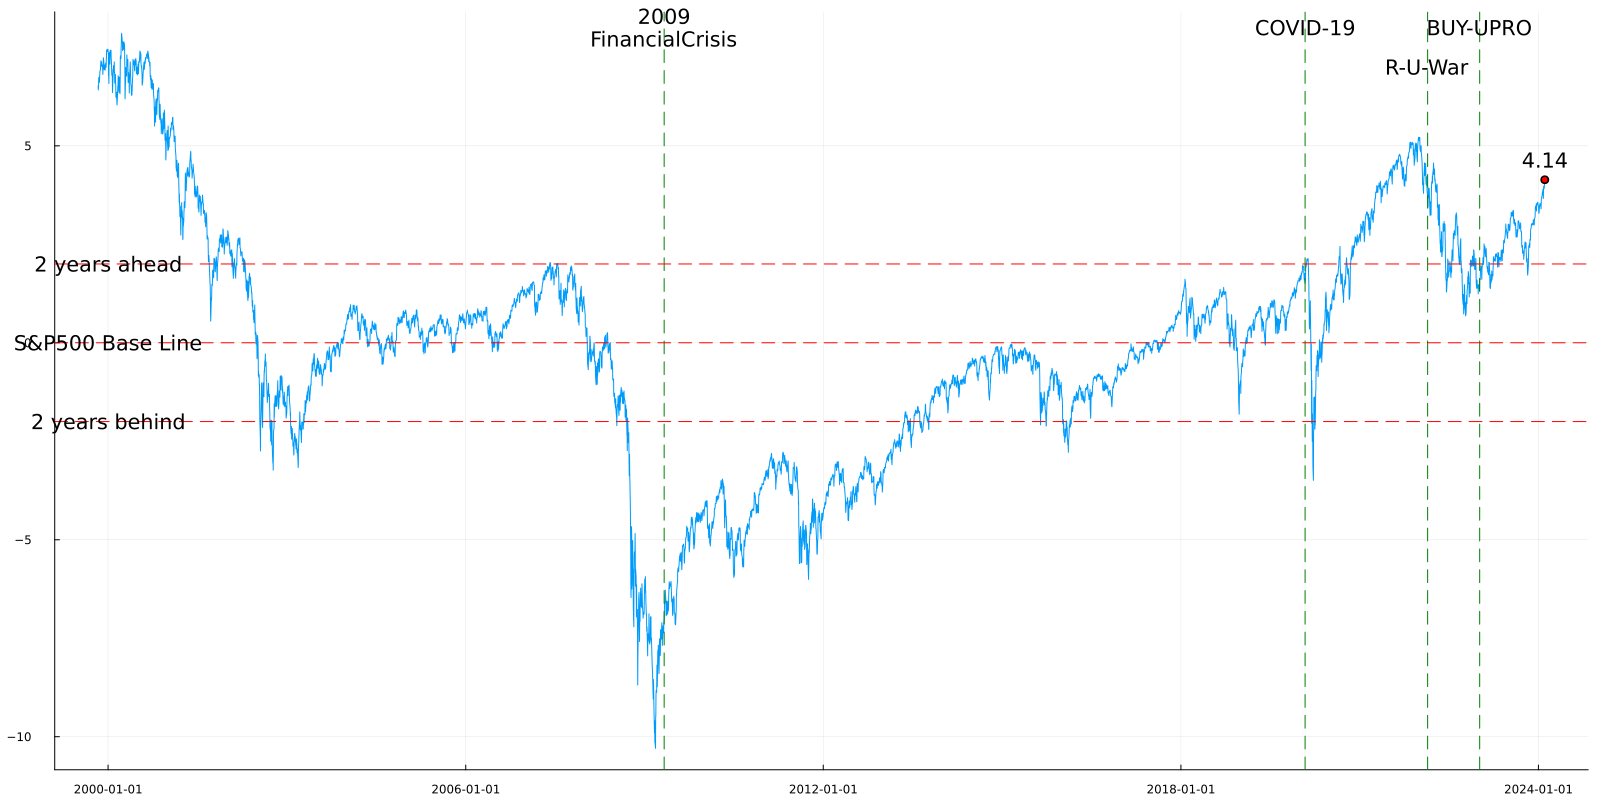

In [10]:
latest_plot = plot(data.timestamp, data.year_adjusted_log_close, label=false, size=(1600,800))

# Add special events to the plot
add_event("2009-05-01", "2009\nFinancialCrisis", 8)
add_event("2020-02-01", "COVID-19", 8)
add_event("2022-02-21", "R-U-War", 7)
add_event("2023-01-06", "BUY-UPRO", 8)

# Add lines represent how many years the price is ahead or behind
date_annotate = Date("2000-01-01", "yyyy-mm-dd")
hline!([0], label=false, color=:red, linestyle=:dash)
annotate!(date_annotate, 0, text("S&P500 Base Line"))
hline!([2], label=false, color=:red, linestyle=:dash)
annotate!(date_annotate, 2, text("2 years ahead"))
hline!([-2], label=false, color=:red, linestyle=:dash)
annotate!(date_annotate, -2, text("2 years behind"))

# Add current price position with rounded year value
scatter!([data.timestamp[1]], [data.year_adjusted_log_close[1]], label=false, color=:red, markershape=:circle)
annotate!(data.timestamp[1], data.year_adjusted_log_close[1]+0.5, text("$(round(data.year_adjusted_log_close[1], digits=2))"))

# Save plot to file before display
file_name = "results/"*Dates.format(now(), "yyyy-mm-dd")*".png"
isfile(file_name) && rm(file_name)
savefig(latest_plot, file_name);

display(latest_plot)

## Side Note (from ChatGPT)

### Q:
Why the log of price is approximately to the percentage change of price?

### A:

The logarithm of the price ratio (which is equivalent to the log return in financial contexts) is approximately equal to the percentage change in price for small changes. This approximation stems from the mathematical properties of logarithms and their relationship to percentage changes. To understand why, let's look at the mathematics behind it.

Consider two prices of a stock at different times: $P_0$ (initial price) and $P_1$ (later price). The percentage change in the stock price can be calculated as:

$$
\text{Percentage Change} = \left( \frac{P_1 - P_0}{P_0} \right) \times 100
$$

The log return is calculated using the natural logarithm ($ln$) of the ratio of the two prices:

$$
\text{Log Return} = \ln\left(\frac{P_1}{P_0}\right) = \ln(P_1) - \ln(P_0)
$$

To see why the log return is approximately equal to the percentage change for small changes, we can use the Taylor series expansion of the natural logarithm function $\ln(1 + x)$ around $x = 0$:

$$
\ln(1 + x) \approx x - \frac{x^2}{2} + \frac{x^3}{3} - \ldots
$$

For small values of $ x $, where $ x = \frac{P_1 - P_0}{P_0} $, the higher-order terms ($ x^2, x^3, \ldots $) become negligible, and the equation simplifies to:

$$
\ln(1 + x) \approx x
$$

Substituting $ x = \frac{P_1 - P_0}{P_0} $, we get:

$$
\ln\left(\frac{P_1}{P_0}\right) \approx \frac{P_1 - P_0}{P_0}
$$

Thus, for small changes in price ($P_1$ close to $P_0$), the log of the price ratio $\ln \left( \frac{P_1}{P_0} \right)$ is approximately equal to the percentage change $\frac{P_1 - P_0}{P_0}$. This approximation makes log returns a convenient measure for analyzing financial data, as they provide a simple and intuitive way to express relative changes in price.